# Load and Visualize MgSiO3 melt Data
* Focus on classical simulations of Spera et al. (2011)
    * we only analyze simulations produced with high-pressure potential set of Oganov et al. (2000)
* Also load First Principles MD data from deKoker et al. (2009)

In [1]:
# Set experimental reference based on Ghiorso and Kress (2004)
Pexp = 0
Texp = 1673
wt_exp_constraint=10
adjust_vol = True
Vadj_empirical = 1.03
Padj_empirical = 0


In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import pandas as pd
import pickle
# import emcee

import xmeos
from xmeos import models
from xmeos import datamod

CONSTS = models.CONSTS

## Load Analysis File
* This pickle file stores all of the intermediate results from the notebooks

In [3]:
# Properties of MgSiO3 melt
mass_avg = (24.31+28.09+3*16.0)/5.0 # g/(mol atom)
natom=5


rho_conv = 2.35023*14.1735882
ang_cc_mol = CONSTS['ang3percc']/natom/CONSTS['Nmol'] # (ang^3/atom) / (cc/mol)

def exp_properties_Ghiorso(T, Vconv=ang_cc_mol):
    """
    Ghiorso and Kress 2004
    """
    nmol = 2
    dVdT_SiO2 = 1.007e-3
    dVdT_MgO = 2.887e-3
    dVdT = 0.5*dVdT_SiO2 + 0.5*dVdT_MgO
    
    VT0_SiO2 = 26.71
    VT0_MgO = 12.015
    
    VT0 = 0.5*VT0_SiO2 + 0.5*VT0_MgO
    alpha = dVdT/VT0
    
    VT = VT0*np.exp(alpha*(T-1673))
    print(VT)

    c_MgO = 3349.96
    c_SiO2 = 2321.75
    dcdT_MgO = 275.64e-3
    dcdT_SiO2 = 399.34e-3
    
    c = 0.5*(c_MgO + dcdT_MgO*(T-1673)) + 0.5*(c_SiO2 + dcdT_SiO2*(T-1673))
    
    rho = 1e3*mass_avg/(VT*nmol/5)
    betaS = 1e9/rho/c**2
    KS = 1/betaS
    
    
    #betaT_MgO = 0.5*VT_MgO/VT*0.615e-2
    #betaT_SiO2 = 0.5*VT_SiO2/VT*7.15e-2
    #betaT = betaT_MgO + betaT_SiO2
    #K = 1/betaT
    
    props = {}
    props['P'] = 0
    props['T'] = T
    props['V'] = VT*nmol*Vconv
    props['alpha'] = alpha
    props['c'] = c
    props['rho'] = rho
    props['betaS'] = betaS
    props['KS'] = KS
    return props

def exp_properties_Lange(T, Vconv=ang_cc_mol):
    """
    Lange 1997 and Ai and Lange 2004
    """
    nmol = 2

    # V0T = +12.02
    dVdT = (0.5*0+0.5*3.27)*1e-3
    
    VT_SiO2 = 26.86
    VT_MgO = 12.02 + 3.27e-3*(T-1773)
    
    VT = 0.5*VT_SiO2 + 0.5*VT_MgO
    
    alpha = dVdT/VT
    # print(VT)
    
    betaT_MgO = 0.5*VT_MgO/VT*0.615e-2
    betaT_SiO2 = 0.5*VT_SiO2/VT*7.15e-2
    betaT = betaT_MgO + betaT_SiO2
    # print(1/betaT)
    # dVdP = (0.5*-1.922 + 0.5*-.073)
    # K = -VT/dVdP
    K = 1/betaT
 
    
    props = {}
    props['P'] = 0
    props['T'] = T
    props['V'] = nmol*VT*Vconv
    props['dVdT'] = dVdT
    props['alpha'] = alpha
    props['betaT'] = betaT
    props['KT'] = K
    return props
    
    pass
    

props_3000 = exp_properties_Lange(3000)
props_Ghiorso = exp_properties_Ghiorso(Texp)
props_Lange = exp_properties_Lange(Texp)

display(props_Lange)
display(props_Ghiorso)
display(props_3000)
exp_props = props_Lange

19.3625


{'KT': 19.3500111762087,
 'P': 0,
 'T': 1673,
 'V': 12.803751383249672,
 'alpha': 8.481830207765933e-05,
 'betaT': 0.05167955671413378,
 'dVdT': 0.001635}

{'KS': 20.850204971850488,
 'P': 0,
 'T': 1673,
 'V': 12.860873922038328,
 'alpha': 0.0001005551969012266,
 'betaS': 0.047961159199637761,
 'c': 2835.855,
 'rho': 2592.6404131697873}

{'KT': 21.24339187023094,
 'P': 0,
 'T': 3000,
 'V': 14.244863367785806,
 'alpha': 7.623747764458367e-05,
 'betaT': 0.04707346200214537,
 'dVdT': 0.001635}

In [4]:

def read_data_Spera2011(exp_props=exp_props):
    title = 'Spera2011'
    delT = 500
    datasource = 'data/MgSiO3-Oganov-md-Spera2011.csv'
    data = pd.read_csv(datasource)
    natom = 5
    
    # Vconv = CONSTS['ang3percc']*mass_avg/CONSTS['Nmol'] # (ang^3/atom) / (cc/g)
    Econv = 1/CONSTS['kJ_molpereV']/natom # (eV/atom) / (kJ/mol formula)
    Vconv = 1
    

    V = data['V [ang3/atom]']
    P = data['P [GPa]']
    trust = np.tile(True, data.shape[0])
    # trust[V>13] = False

    data = datamod.load_data(P=P,V=V, 
                             T=data['T [K]'], E=data['Etot [kJ/mol]'],
                             Perr=data['P_err [GPa]'],
                             Terr=data['T_err [K]'], 
                             Eerr=data['Etot_err [kJ/mol]'],
                             trust=trust,
                             title=title, datasource=datasource,
                             Vconv=Vconv, Econv=Econv, mass_avg=mass_avg)
    
    
    KT_exp = exp_props['KT']
    KT_exp = None
    alpha = exp_props['alpha']
    alpha = None
    datamod.set_exp_constraint(data, exp_props['V'], exp_props['T'], 
                               exp_props['P'], KT=KT_exp,
                               alpha=alpha, wt=wt_exp_constraint)
    
    # datamod.set_uncertainty_scale(data)
    tbl = data['table']
    
    tbl['T_label'] = delT*np.round(tbl['T']/delT)
    Tlbl = np.unique(tbl['T_label'])
    T_avg = []
    for iTlbl in Tlbl:
        iTmask = tbl['T_label']==iTlbl
        T_avg.append(np.mean(tbl['T'][iTmask]))
        
    data['T_avg'] = T_avg
    data['T_labels'] = Tlbl
    
    Vlbl = np.unique(tbl['V'])
    tbl['V_label'] = np.round(tbl['V'], decimals=2)
    data['V_labels'] = Vlbl
    
    return data

def read_data_deKoker2009(exp_props=exp_props):
    title = 'deKoker2009'
    delT = 1000
    datasource = 'data/MgSiO3-fpmd-deKoker2009.csv'
    VX = 38.9 #cc^3/mol formula (From Stixrude and ddKarki 2005)
    natom = 5
    
    # E = [kJ/mol formula]
    Vconv = CONSTS['ang3percc']/natom/CONSTS['Nmol'] # (ang^3/atom) / (cc/mol)
    Econv = 1/natom/CONSTS['kJ_molpereV'] # (eV/atom) / (kJ/mol)
    
    data = pd.read_csv(datasource)
    data = datamod.load_data(V=VX*data['V/VX'], P=data['P'],
                             T=data['T'], E=data['E'],
                             title=title, datasource=datasource,
                             Vconv=Vconv, Econv=Econv, mass_avg=mass_avg)
    
    KT_exp = exp_props['KT']
    KT_exp = None
    datamod.set_exp_constraint(data, exp_props['V'], exp_props['T'], 
                               exp_props['P'], KT=KT_exp,wt=wt_exp_constraint)

    tbl = data['table']
    
    tbl['T_label'] = delT*np.round(tbl['T']/delT)
    Tlbl = np.unique(tbl['T_label'])
    T_avg = []
    for iTlbl in Tlbl:
        iTmask = tbl['T_label']==iTlbl
        T_avg.append(np.mean(tbl['T'][iTmask]))
        
    data['T_avg'] = T_avg
    data['T_labels'] = Tlbl
    
    delT = np.min(np.diff(Tlbl))
    Tlbl = np.arange(Tlbl[0],Tlbl[-1]+delT/2,delT)
    data['T_labels'] = Tlbl
    
    Vlbl = np.unique(tbl['V'])
    tbl['V_label'] = np.round(tbl['V'], decimals=2)
    data['V_labels'] = Vlbl
    
    return data

def make_multi_dataset(datasets):
    title = 'multi'
    datasource = 'multi'
    
    delT = 500
    tbl_S11 = datasets['Spera2011']['table']
    tbl_dK09= datasets['deKoker2009']['table'].copy()
    tbl_dK09['E'] = np.nan


    tbl_hiP = tbl_dK09.loc[tbl_dK09['V']<6]
    

    tbl = pd.concat((tbl_S11.loc[tbl_S11['V']<11],
                             tbl_dK09.loc[tbl_dK09['V']>14],
                             tbl_hiP.loc[tbl_hiP['T']<7500]
                            ))

    data = datamod.load_data(V=tbl['V'], P=tbl['P'],
                             T=tbl['T'], E=tbl['E'],
                             title=title, datasource=datasource,
                             mass_avg=mass_avg)

    KT_exp = exp_props['KT']
    # KT_exp = None
    alpha = exp_props['alpha']
    datamod.set_exp_constraint(data, exp_props['V'], exp_props['T'], 
                               exp_props['P'], KT=KT_exp,
                               alpha=alpha, wt=wt_exp_constraint)
    
    tbl['T_label'] = delT*np.round(tbl['T']/delT)
    Tlbl = np.unique(tbl['T_label'])
    T_avg = []
    for iTlbl in Tlbl:
        iTmask = tbl['T_label']==iTlbl
        T_avg.append(np.mean(tbl['T'][iTmask]))
        
    data['T_avg'] = T_avg
    data['T_labels'] = Tlbl
    
    delT = np.min(np.diff(Tlbl))
    Tlbl = np.arange(Tlbl[0],Tlbl[-1]+delT/2,delT)
    data['T_labels'] = Tlbl
    
    Vlbl = np.unique(tbl['V'])
    tbl['V_label'] = np.round(tbl['V'], decimals=2)
    data['V_labels'] = Vlbl
    

    return data
        
def load_datasets():
    datasets = {}
    datasets['Spera2011'] = read_data_Spera2011()
    datasets['deKoker2009'] = read_data_deKoker2009()
    datasets['multi'] = make_multi_dataset(datasets)
    return datasets

datasets = load_datasets()


In [5]:
# datasets['multi']

In [6]:

# plt.figure()
# plt.scatter(tbl_multi['V'], tbl_multi['P'],c=tbl_multi['T'])

# plt.figure()
# plt.scatter(tbl_multi['V'], tbl_multi['E'],c=tbl_multi['T'])


In [7]:
analysis_file = 'data/analysis.pkl'
try:
    with open(analysis_file, 'rb') as f:
        analysis = pickle.load(f)
except:
    analysis = {}

In [8]:
data = datasets['Spera2011']
# data = datasets['multi']
# View data tables
tbl = data['table']
tbl.head()

,V,T,P,E,trust,Verr,Terr,Perr,Eerr,T_label,V_label
0,14.173588,2559,-0.88,-20.738626,True,0,19,0.19,0.000083,2500.0,14.17
1,14.173588,3058,-0.77,-20.569655,True,0,22,0.21,0.000021,3000.0,14.17
2,14.173588,3537,-0.59,-20.409099,True,0,24,0.21,0.000021,3500.0,14.17
3,14.173588,4005,-0.33,-20.256400,True,0,29,0.24,0.000041,4000.0,14.17
4,14.173588,4484,0.01,-20.106291,True,0,32,0.24,0.000021,4500.0,14.17


In [9]:
def estimate_data_adjustment(data, Pthresh=50):
    eos_compress = models.CompressEos(kind='Vinet', path_const='T')
    tbl = data['table']
    
    VT0 = np.zeros(len(data['T_avg']))
    PT0 = np.zeros(len(data['T_avg']))

    for ind, iT in enumerate(data['T_labels']):
        imsk_T = tbl['T_label']==iT
        itbl = tbl.loc[imsk_T]
        iV = itbl['V']
        iP = itbl['P']

        idata = datamod.load_data(V=iV[iP<Pthresh], P=iP[iP<Pthresh])
        idatamodel = datamod.init_datamodel(idata, eos_compress)
   
        fit_calcs = ['compress']
        datamod.select_fit_params(idatamodel, fit_calcs)
    
        datamod.fit(idatamodel)
        iVT0, iKT0, iKPT0 = idatamodel['eos_mod'].get_param_values(param_names=['V0','K0','KP0'])

        VT0[ind] = iVT0
        PT0[ind] = idatamodel['eos_mod'].press(data['exp_constraint']['V'])

    poly_VT0 = np.polyfit(data['T_avg'], VT0,2);
    poly_PT0 = np.polyfit(data['T_avg'], PT0,2)
    
    Vscale = data['exp_constraint']['V']/np.polyval(
        poly_VT0, data['exp_constraint']['T'])
    Pshift = -np.polyval(poly_PT0,data['exp_constraint']['T'])
    return Vscale, Pshift

def apply_data_adjustment(data, Vscale=None, Pshift=None):
    tbl = data['table']
    
    if Vscale is not None:
        tbl['V'] = Vscale*tbl['V']
        return
    
    if Pshift is not None:
        tbl['P'] = tbl['P']+Pshift
        return

# Vscale, Pshift = estimate_data_adjustment(data)
# print('Vscale = ', Vscale)
# print('Pshift (equiv) = ', Pshift)


# apply_data_adjustment(data, Vscale=Vadj_empirical, Pshift=Padj_empirical)
# apply_data_adjustment(data, Pshift=Padj_empirical)


# Vscale1, Pshift1 = estimate_data_adjustment(data)
# print('Vscale1 = ', Vscale1)
# print('Pshift1 (equiv) = ', Pshift1)

In [10]:
# Store data for later use
analysis['composition'] = 'MgSiO3'
analysis['datasets'] = datasets
analysis['props_Ghiorso'] = props_Ghiorso
analysis['props_Lange'] = props_Lange
analysis['props_3000'] = props_3000

with open(analysis_file, 'wb') as f:
    pickle.dump(analysis, f)


## Visualize MD data of Spera et al. (2011)

<IPython.core.display.Javascript object>


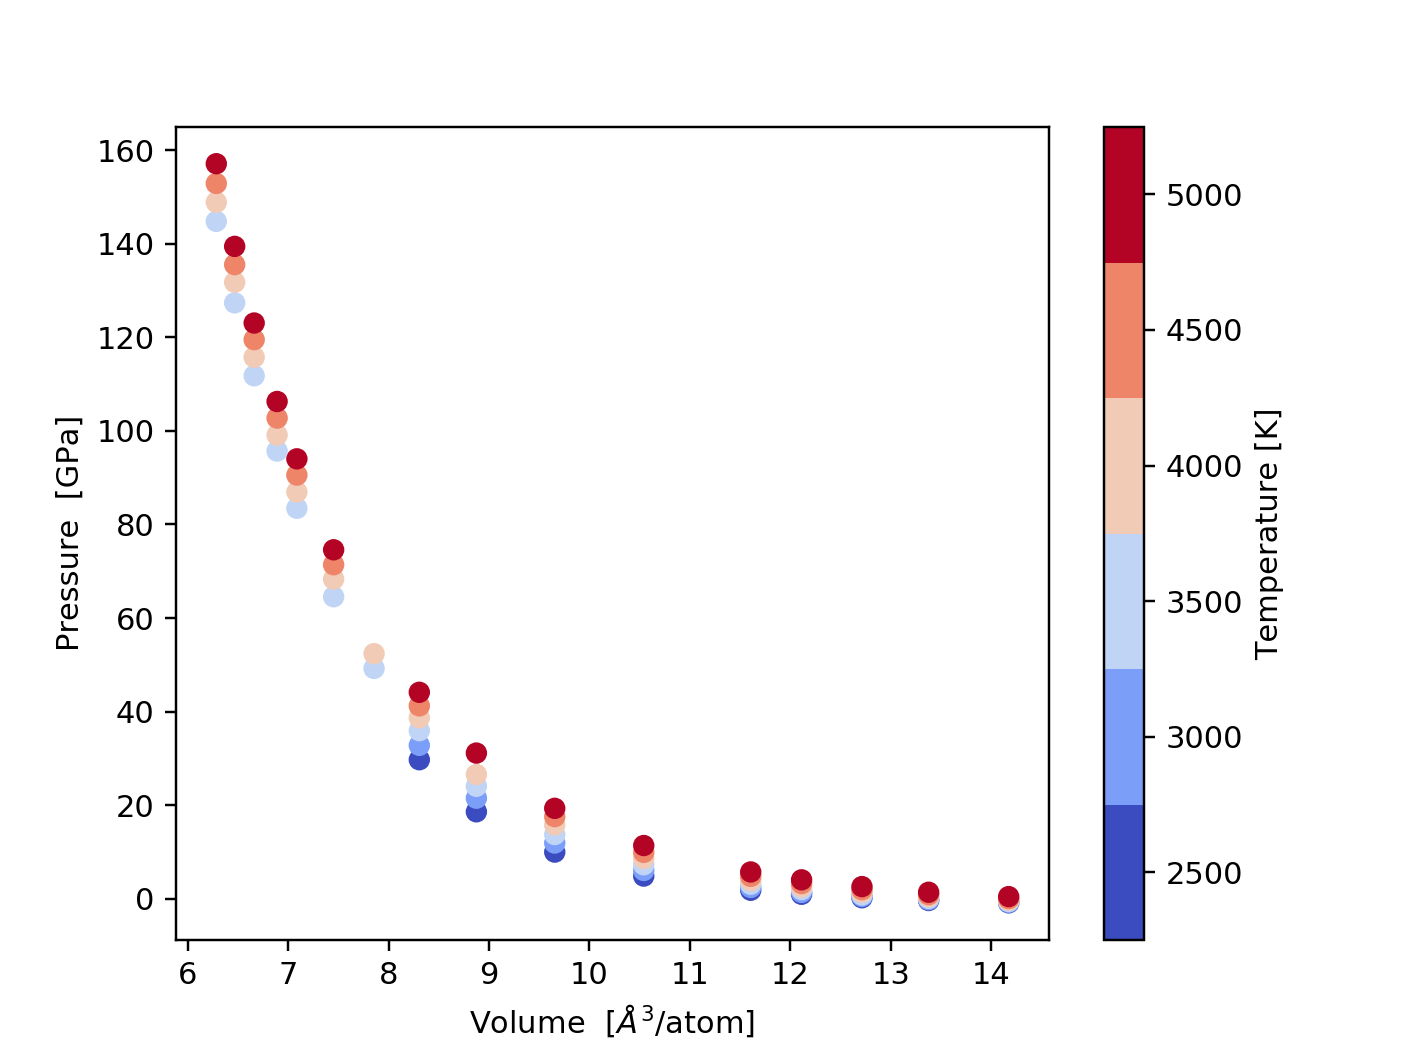

<IPython.core.display.Javascript object>


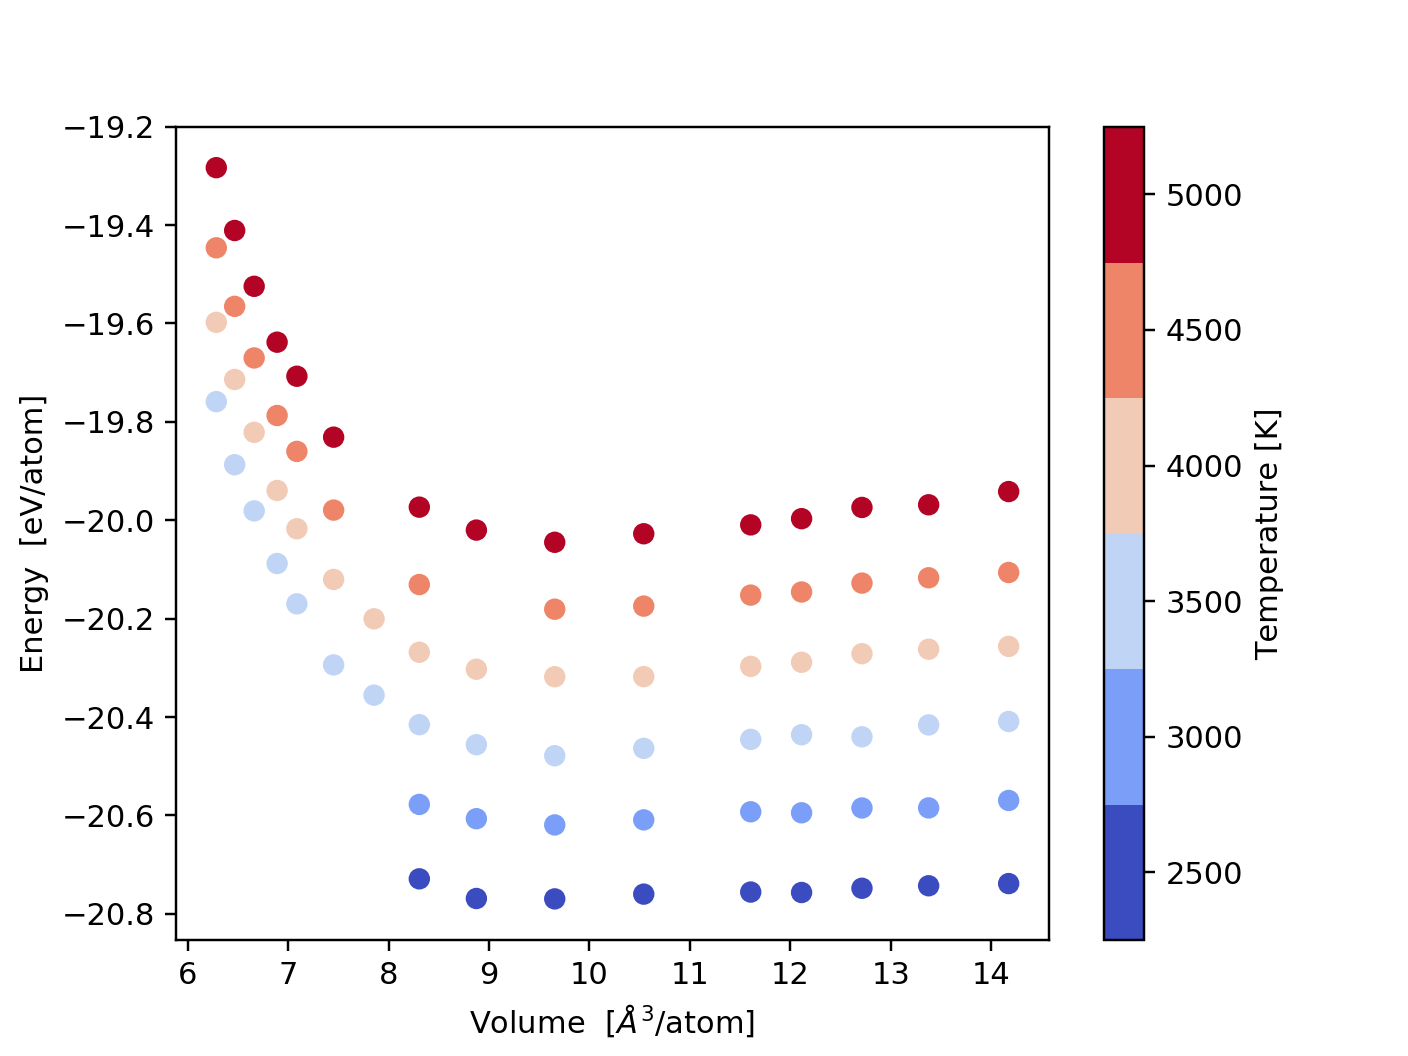

In [11]:
# Set colorbar temperature properties
cmap = plt.get_cmap('coolwarm',len(data['T_labels']))
delT = np.diff(data['T_labels'])[0]



plt.figure()
plt.scatter(tbl['V'],tbl['P'],c=tbl['T'], cmap=cmap)
plt.xlabel(r'Volume  [$\AA^3$/atom]')
plt.ylabel(r'Pressure  [GPa]')
cbar = plt.colorbar()
cbar.set_ticks(data['T_labels'])
cbar.set_label('Temperature [K]')
plt.clim(data['T_labels'][0]-delT/2,data['T_labels'][-1]+delT/2)


plt.figure()
plt.scatter(tbl['V'],tbl['E'],c=tbl['T'], cmap=cmap)
plt.xlabel(r'Volume  [$\AA^3$/atom]')
plt.ylabel(r'Energy  [eV/atom]')
cbar = plt.colorbar()
cbar.set_ticks(data['T_labels'])
cbar.set_label('Temperature [K]')
plt.clim(data['T_labels'][0]-delT/2,data['T_labels'][-1]+delT/2)